In [1]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.util import everygrams
from nltk.lm.preprocessing import padded_everygram_pipeline
from collections import Counter

from tensorflow.keras.utils import pad_sequences
from collections import Counter
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False, nb_workers = 8)
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

2023-08-13 14:52:33.611759: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-13 14:52:34.174163: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-13 14:52:35.883423: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
df = pd.read_csv('../data/processed_data.csv')

In [4]:
sample_df = df.sample(frac=1).iloc[:].reset_index()
sample_df.drop(sample_df.columns[:-1], axis=1, inplace=True)
sample_df.head()

,preprocessed text
0,<bos> lowbudget film writer goes work london c...
1,<bos> loved movie scenery breathtaking plot ni...
2,<bos> march new york times article described c...
3,<bos> watched pretty damn awesome fights fanta...
4,<bos> cell fascinated first glance bit surpris...


In [5]:
n_grms = sample_df['preprocessed text'].parallel_apply(lambda a: list(everygrams(a.split(),  max_len=3)))

In [6]:
ngrams = []
for seq in n_grms.to_list():
    ngrams += seq


In [7]:
counter = Counter(ngrams)

In [38]:
non_unigrams = list(filter(lambda a: len(a)>1, counter))
non_unigrams_counter = {n_gram : counter[n_gram] for n_gram in non_unigrams}
                                    
non_unigrams_counter = pd.DataFrame(non_unigrams_counter.items(), \
                                    index=[' '.join(text) for text in non_unigrams_counter.keys()], columns=['ngram', 'count'])\
                                    .sort_values(by=['count'], ascending=False)
non_unigrams_counter.reset_index(inplace=True)
non_unigrams_counter.drop(columns=['index'], inplace=True)
non_unigrams_counter['ngram_len'] = non_unigrams_counter['ngram'].apply(len)
non_unigrams_counter['ngram'] = non_unigrams_counter['ngram'].parallel_apply(lambda a: ' '.join(a))

In [39]:
non_unigrams_counter

,ngram,count,ngram_len
0,br br,101263,2
1,ever seen,2669,2
2,br film,2655,2
3,br br film,2655,3
4,br br movie,2511,3
...,...,...,...
7860175,matrix no idea,1,3
7860176,memento matrix no,1,3
7860177,memento matrix,1,2
7860178,seen memento matrix,1,3


In [40]:
non_unigrams_counter['count'].sum()

11570026

In [41]:
non_unigrams_counter['freq'] = non_unigrams_counter['count'] / non_unigrams_counter['count'].sum()
non_unigrams_counter['log_freq'] = non_unigrams_counter['freq'].parallel_apply(np.log10)
non_unigrams_counter['log_abs_log_freq'] = non_unigrams_counter['log_freq'].parallel_apply(lambda a: np.log10(np.abs(a)))

In [43]:
non_unigrams_counter.describe()

,count,ngram_len,freq,log_freq,log_abs_log_freq
count,7.860180e+06,7.860180e+06,7.860180e+06,7.860180e+06,7.860180e+06
mean,1.471980e+00,2.649180e+00,1.272235e-07,-7.008495e+00,8.454579e-01
std,3.676431e+01,4.772268e-01,3.177548e-06,1.854412e-01,1.233117e-02
min,1.000000e+00,2.000000e+00,8.643023e-08,-7.063334e+00,3.134208e-01
25%,1.000000e+00,2.000000e+00,8.643023e-08,-7.063334e+00,8.490098e-01
50%,1.000000e+00,3.000000e+00,8.643023e-08,-7.063334e+00,8.490098e-01
75%,1.000000e+00,3.000000e+00,8.643023e-08,-7.063334e+00,8.490098e-01
max,1.012630e+05,3.000000e+00,8.752184e-03,-2.057884e+00,8.490098e-01


In [31]:
def plot_ngram_stat(col_to_plot, data):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(15, 10)
    for col in col_to_plot:
        axs[0].hist(data[col].values, bins=50, label=col)

    axs[1].boxplot(data[col_to_plot].values, labels = col_to_plot)
    # axs[1].boxplot(non_unigrams_counter['count'].values)
    axs[0].grid()
    axs[0].legend()
    axs[1].grid()

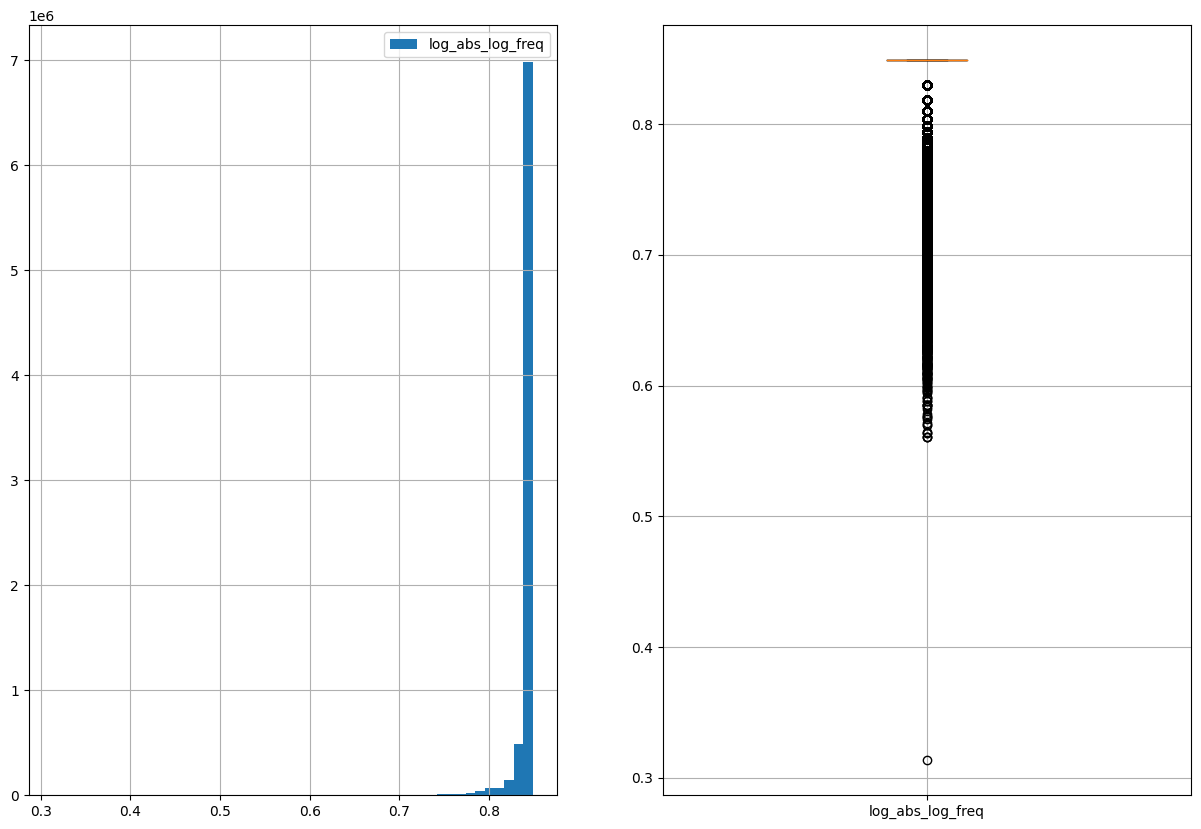

In [60]:
plot_ngram_stat(non_unigrams_counter.columns[5:], non_unigrams_counter)

In [44]:
min_threshold_count_ngram, max_threshold_count_ngram = 50, 100_000

In [45]:
ngrams_to_filter = non_unigrams_counter[(non_unigrams_counter['count'] < min_threshold_count_ngram) | (non_unigrams_counter['count'] > max_threshold_count_ngram )]
filtred_non_unigrams_counter = non_unigrams_counter.drop(ngrams_to_filter.index,axis=0, inplace=False)


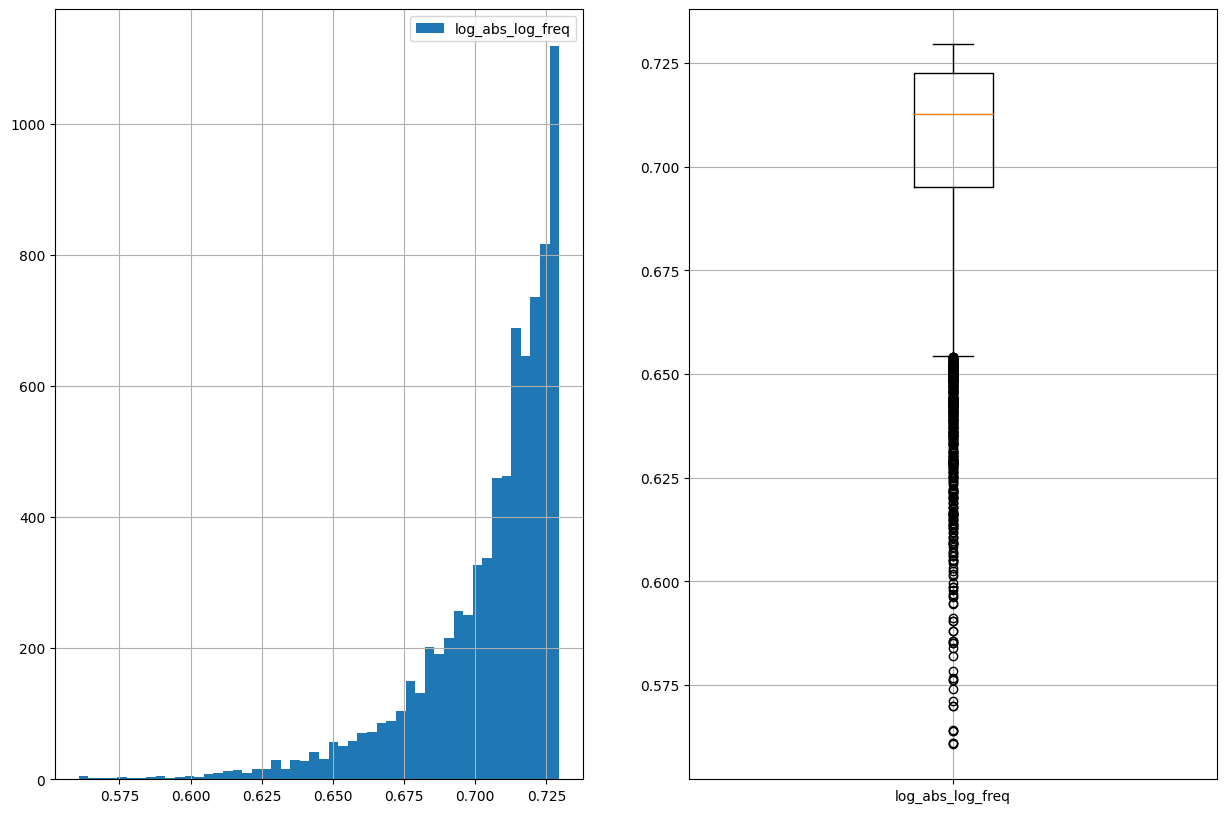

In [58]:
plot_ngram_stat(non_unigrams_counter.columns[5:], filtred_non_unigrams_counter)

In [54]:
filtred_non_unigrams_counter.describe()

,count,ngram_len,freq,log_freq,log_abs_log_freq
count,7870.000000,7870.000000,7870.000000,7870.000000,7870.000000
mean,128.351715,2.119822,0.000011,-5.077601,0.704992
std,165.562955,0.324774,0.000014,0.272458,0.024473
min,50.000000,2.000000,0.000004,-5.364364,0.560742
25%,61.000000,2.000000,0.000005,-5.278004,0.695142
50%,80.000000,2.000000,0.000007,-5.160244,0.712670
75%,128.000000,2.000000,0.000011,-4.956124,0.722470
max,2669.000000,3.000000,0.000231,-3.636986,0.729518


# Написание фунций обработки текстов. Токенизация текста N-gram 1-3